In [25]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText
from matplotlib.colors import Normalize
import matplotlib.colors as colors
import matplotlib.cm as cm
from datetime import datetime, timedelta
import os
import netCDF4
import bisect
from matplotlib.pyplot import figure

In [2]:
def get_current_data_subset(nc_file, x_0, x_T, deg_around_x0_xT_box, fixed_time=None,
                            temporal_stride=1, temp_horizon_in_h=None):
    """ Function to read a subset of the nc_file current data bounded by a box spanned by the x_0 and x_T points.
    Inputs:
        nc_file                 full path to nc file
        x_0                     [lat, lon, charge, timestamp in POSIX]
        x_T                     [lon, lat] goal locations
        deg_around_x0_xT_box    float, buffer around the box in degrees
        fixed_time              if None returns time-varying currents, 
                                otherwise datetime object of the fixed time -> returns ocean current grid at or before time
                                the time of x_0 is then ignored
        temporal_stride         int, if a stride of the temporal values is used (every temporal_stride hours)
        temp_horizon            if None: all available time of the file will be provided
                                otherwise float, maximum temp_horizon to look ahead of x_0 time in hours
                                
    Outputs:
        grids_dict              dict containing x_grid, y_grid, t_grid, fixed_time_idx
        u_data                  [T, Y, X] matrix of the ocean currents in x direction in m/s
        v_data                  [T, Y, X] matrix of the ocean currents in y direction in m/s
        
    """
    
    f = netCDF4.Dataset(nc_file)

    # extract positiond & start_time for the indexing
    x_0_pos = x_0[:2]
    x_0_posix_time = x_0[3]
    x_T = x_T[:2]

    # Step 1: get the grids
    xgrid = f.variables['lon'][:]
    ygrid = f.variables['lat'][:]
    t_grid = f.variables['time'][:] # not this is in hours from HYCOM data!
    
    # this is needed because the time origin in hindcast and forecase nc files is different. Very handcrafted.
    try:
        time_origin = datetime.strptime(f.variables['time'].__dict__['time_origin'] + ' +0000',
                                    '%Y-%m-%d %H:%M:%S %z')
    except:
        time_origin = datetime.strptime(f.variables['time'].__dict__['units'] + ' +0000',
                                                 'hours since %Y-%m-%d %H:%M:%S.000 UTC %z')

    # Step 2: find the sub-setting
    # find the lat & lon sub-set bounds
    lon_bnds = [min(x_0_pos[0], x_T[0]) - deg_around_x0_xT_box, max(x_0_pos[0], x_T[0]) + deg_around_x0_xT_box]
    lat_bnds = [min(x_0_pos[1], x_T[1]) - deg_around_x0_xT_box, max(x_0_pos[1], x_T[1]) + deg_around_x0_xT_box]

    # get the respective indices from the grids
    ygrid_inds = np.where((ygrid > lat_bnds[0]) & (ygrid < lat_bnds[1]))[0]
    xgrid_inds = np.where((xgrid > lon_bnds[0]) & (xgrid < lon_bnds[1]))[0]

    # for time indexing transform to POSIX time
    abs_t_grid = [(time_origin + timedelta(hours=X)).timestamp() for X in t_grid.data]
    
    # get the idx of the value left of the demanded time (for interpolation function)
    t_start_idx = bisect.bisect_right(abs_t_grid, x_0_posix_time) - 1
    if t_start_idx == len(abs_t_grid) - 1 or t_start_idx == -1:
        raise ValueError("Requested subset time is outside of the nc4 file.")

    # get the max time if provided as input
    if temp_horizon_in_h is None:   # all data provided
        t_end_idx = len(abs_t_grid)-1
    else:
        t_end_idx = bisect.bisect_right(abs_t_grid, x_0_posix_time + temp_horizon_in_h*3600.)
        if t_end_idx == len(abs_t_grid):
            raise ValueError("nc4 file does not contain requested temporal horizon.")

    # fixed time logic if necessary
    if fixed_time is None:
        slice_for_time_dim = np.s_[t_start_idx:(t_end_idx+1):temporal_stride]
        fixed_time_idx = None
    else:
        fixed_time_idx = bisect.bisect_right(abs_t_grid, fixed_time.timestamp()) - 1
        slice_for_time_dim = np.s_[fixed_time_idx]

    # Step 2: extract data
    # raw water_u is [tdim, zdim, ydim, xdim]
    if len(f.variables['water_u'].shape) == 4:  # if there is a depth dimension in the dataset
        u_data = f.variables['water_u'][slice_for_time_dim, 0, ygrid_inds, xgrid_inds]
        v_data = f.variables['water_v'][slice_for_time_dim, 0, ygrid_inds, xgrid_inds]
    # raw water_u is [tdim, ydim, xdim]
    elif len(f.variables['water_u'].shape) == 3:  # if there is no depth dimension in the dataset
        u_data = f.variables['water_u'][slice_for_time_dim, ygrid_inds, xgrid_inds]
        v_data = f.variables['water_v'][slice_for_time_dim, ygrid_inds, xgrid_inds]
    else:
        raise ValueError("Current data in nc file has neither 3 nor 4 dimensions. Check file.")

    # create dict to output
    grids_dict = {'x_grid': xgrid[xgrid_inds], 'y_grid': ygrid[ygrid_inds],
                  't_grid': abs_t_grid[slice_for_time_dim], 'fixed_time_idx': fixed_time_idx}

    # log what data has been subsetted
    if fixed_time is None:
        print("Subsetted data from {start} to {end} in {n_steps} time steps of {time:.2f} hour(s) resolution".format(
            start=datetime.utcfromtimestamp(grids_dict['t_grid'][0]).strftime('%Y-%m-%d %H:%M:%S UTC'),
            end=datetime.utcfromtimestamp(grids_dict['t_grid'][-1]).strftime('%Y-%m-%d %H:%M:%S UTC'),
            n_steps=len(grids_dict['t_grid']), time=(grids_dict['t_grid'][1] - grids_dict['t_grid'][0])/3600.))
    else:
        print("Subsetted data to fixed time at: {time}".format(
            time=datetime.utcfromtimestamp(grids_dict['t_grid'][0]).strftime('%Y-%m-%d %H:%M:%S UTC')))

    #TODO: we replace the masked array with fill value 0 because otherwise interpolation doesn't work.
    # Though that means we cannot anymore detect if we're on land or not (need a way to do that/detect stranding)
    # not sure yet if we'll do it in the simulator or where.
    # return grids_dict, u_data.filled(fill_value=0.), v_data.filled(fill_value=0.)
    return grids_dict, u_data, v_data

In [3]:
hindcast_file = '2021_06_1-05_hourly.nc4'
x_0 = [-88.0, 25.0, 1, 1622549410.0]  # lon, lat, battery, posix_time
x_T = [-88.0, 26.3]
deg_around_x0_xT_box = 0.5
fixed_time = None
temporal_stride = 1

# function call
grids_dict, u_data, v_data = get_current_data_subset(hindcast_file,
                                                     x_0, x_T,
                                                     deg_around_x0_xT_box,
                                                     fixed_time,
                                                     temporal_stride)


Subsetted data from 2021-06-01 12:00:00 UTC to 2021-06-06 11:00:00 UTC in 120 time steps of 1.00 hour(s) resolution


In [4]:
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [6]:
plot_times = grids_dict['t_grid']
time = plot_times[-1]

In [26]:
def visualize_currents(time, grids_dict, u_data, v_data, vmin=0, vmax=None, alpha=0.5,
                       autoscale = False, plot=True, reset_plot=False, figsize=(12,12)):
    """ Function to visualize ocean currents and optionally build visualization capabilities on top.
    Inputs:
        time                    time to plot the currents (timestamp in POSIX)
        grids_dict              dict containing x_grid, y_grid, t_grid, fixed_time_idx
        u_data                  [T, Y, X] matrix of the ocean currents in x direction in m/s
        v_data                  [T, Y, X] matrix of the ocean currents in y direction in m/s
        
        Optional:
        vmin                    minimum current magnitude used for colorbar (float)
        vmax                    maximum current magnitude used for colorbar (float)
        alpha                   alpha of the current magnitude color visualization
        autoscale               True or False whether the plot is scaled to the figsize or lat-lon proportional
        plot                    if True: plt.show() is called directly, if False ax object is return to add things
        reset_plot              if True the current figure is resetted and no figure is created (used for animation)
        figsize                 size of the figure (per default (12,12))
                          
    Outputs:
        ax object               if plot=False an ax object is returned to add further points/lines to the plot
    """
    
    # reset plot this is needed for matplotlib.animation
    if reset_plot:
        plt.clf()
    else: # create a new figure object where it this is plotted
        fig = plt.figure(figsize=figsize)
        
    # Step 0: Create the figure and cartophy axis object and things (ocean, land-boarders,grid_lines, etc.)
    ax = plt.axes(projection=ccrs.PlateCarree())
    # ax.add_feature(cfeature.OCEAN, zorder=0)
    ax.coastlines(resolution='50m')
    ax.add_feature(cfeature.LAND, zorder=0, edgecolor='black')
    grid_lines = ax.gridlines(draw_labels=True)
    grid_lines.top_labels = False
    grid_lines.right_labels = False
    ax.set_title("Time: " + datetime.utcfromtimestamp(time).strftime('%Y-%m-%d %H:%M:%S UTC'))

    # Step 1: perform time-interpolation on the current data
    # Note: let's outsource that to utils? Especially when we do animation, makes sens to create it once.
    u_currents = interp1d(grids_dict['t_grid'], u_data, axis=0, kind='linear')(time)
    v_currents = interp1d(grids_dict['t_grid'], v_data, axis=0, kind='linear')(time)

    # get current vector magnitude in m/s
    magnitude = (u_currents ** 2 + v_currents ** 2) ** 0.5

    # Step 2: plot the current vectors in black
    X, Y = np.meshgrid(grids_dict['x_grid'], grids_dict['y_grid'], indexing='xy')
    plt.quiver(X, Y, u_currents, v_currents)

    # Step 3: underly the current magnitude in color
    if vmax is None:
        vmax = np.max(magnitude)
    if autoscale:
        plt.imshow(magnitude, extent=[grids_dict['x_grid'][0],grids_dict['x_grid'][-1],
                                      grids_dict['y_grid'][0],grids_dict['y_grid'][-1]],
                   aspect='auto',
                   cmap='jet', vmin=vmin, vmax=vmax, alpha=alpha)
    else:
        plt.imshow(magnitude, extent=[grids_dict['x_grid'][0],grids_dict['x_grid'][-1],
                                      grids_dict['y_grid'][0],grids_dict['y_grid'][-1]],
                   cmap='jet', vmin=vmin, vmax=vmax, alpha=alpha)

    # Step 4: set and format colorbar
    cbar = plt.colorbar()
    cbar.ax.set_title('current velocity')
    cbar.set_ticks(cbar.get_ticks())
    cbar.set_ticklabels(["{:.1f}".format(l) + ' m/s' for l in cbar.get_ticks().tolist()])
    
    # plot the figure
    if plot:
        plt.show()
    else: # return ax object to draw other things on top of this
        return ax

In [43]:
x_0 = [-88, 25]
x_T = [-88, 26]

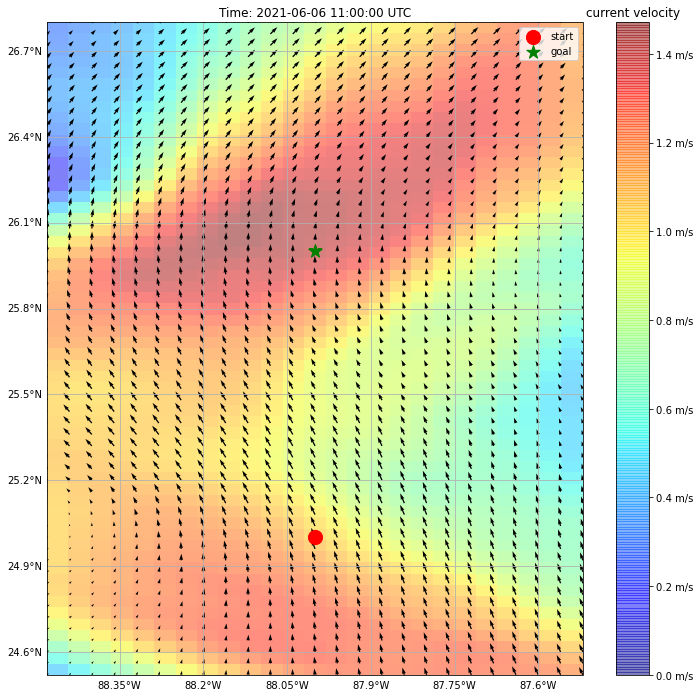

In [47]:
ax = visualize_currents(time, grids_dict, u_data, v_data, autoscale=True, plot=False)
ax.scatter(x_0[0], x_0[1], c='r', marker='o', s=200, label='start')
ax.scatter(x_T[0], x_T[1], c='g', marker='*', s=200, label='goal')
plt.legend(loc='upper right')

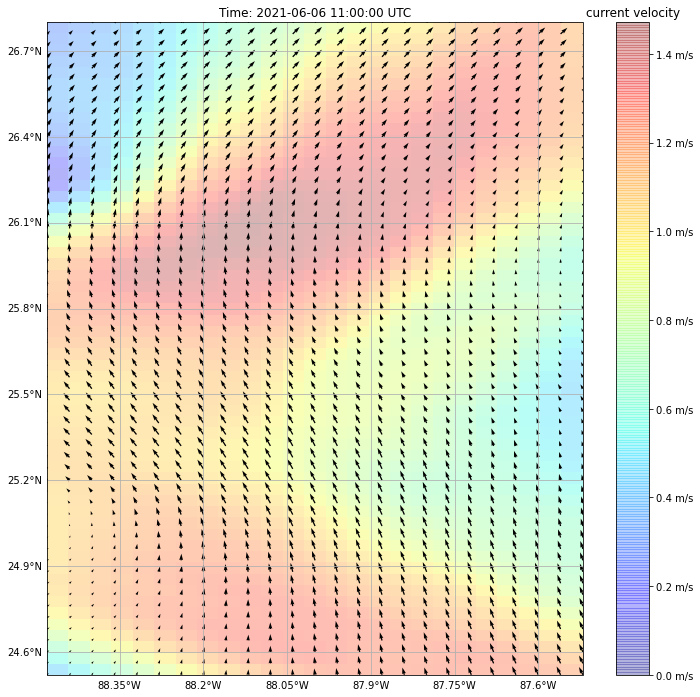

In [22]:
visualize_currents(time, grids_dict, u_data, v_data, autoscale = True, alpha=0.3)

In [ ]:
            ax.scatter(self.x_0[0], self.x_0[1], c='r', marker='o', s=200, label='start')
            ax.scatter(self.x_T[0], self.x_T[1], c='g', marker='*', s=200, label='goal')
            plt.legend(loc='upper right')

In [56]:
from functools import partial
import warnings

def viz_current_animation(plot_times, grids_dict, u_data, v_data, ax_adding_func=None,
                          autoscale = False, interval=250, alpha=0.5, figsize=(12,12),
                          save_as_filename=None):
    """ Function to animate ocean currents.
    Inputs:
        plot_times              vector of times to plot the currents (timestamps in POSIX)
        grids_dict              dict containing x_grid, y_grid, t_grid, fixed_time_idx
        u_data                  [T, Y, X] matrix of the ocean currents in x direction in m/s
        v_data                  [T, Y, X] matrix of the ocean currents in y direction in m/s
        
        Optional:
        alpha                   alpha of the current magnitude color visualization
        autoscale               True or False whether the plot is scaled to the figsize or lat-lon proportional
        interval                interval between frames in ms (for HTML directly in jupyter otherwise fps=10 is fixed)
        figsize                 size of the figure (per default (12,12))
                          
    Outputs:
        file                    if save_as_filename is a string with 'name.gif' a gif will be created or for 
                                'name.mp4' an mp4 file and saved in the currently active folder.
    """
    
    # get rounded up vmax across the whole dataset (with ` decimals)
    vmax = round(((u_data ** 2 + v_data ** 2) ** 0.5).max() + 0.049, 1)
    
    # create global figure object where the animation happens
    fig = plt.figure(figsize=(12,12))
    
    # create full func for rendering the frame
    if ax_adding_func is not None:
        def full_plot_func(time, grids_dict, u_data, v_data, vmax, autoscale, alpha, figsize):
            # plot underlying currents at time
            ax = visualize_currents(time, grids_dict, u_data, v_data, autoscale=autoscale,
                                               plot=False, reset_plot=True, alpha=alpha, figsize=figsize, vmax=vmax)
            # add the ax_adding_func
            ax_adding_func(ax, time)
        
        # create partial func from the full_function
        render_frame = partial(full_plot_func,
                           grids_dict=grids_dict, u_data=u_data, v_data=v_data,
                           vmax=vmax, autoscale=autoscale, alpha=alpha, figsize=figsize)
    else:
        # create a partial function with most variables already set for the animation loop to call
        render_frame = partial(visualize_currents,
                               grids_dict=grids_dict, u_data=u_data, v_data=v_data,
                               vmax=vmax, autoscale=autoscale, plot=False, reset_plot=True,
                               alpha=alpha, figsize=figsize)

    # create animation function object (it's not yet executed)
    ani = animation.FuncAnimation(fig, func=render_frame, fargs=(), frames=plot_times,
                                  interval=interval, repeat=False)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        if save_as_filename is None:
            ani_html = HTML(ani.to_html5_video())
            plt.close(); 
            return ani_html
        elif 'gif' in save_as_filename:
            ani.save(save_as_filename, writer=animation.PillowWriter(fps=10))
            plt.close(); 
        elif 'mp4' in save_as_filename:
            ani.save(save_as_filename, writer=animation.FFMpegWriter(fps=10))
            plt.close();

In [50]:
# animation directly in jupyter
viz_current_animation(plot_times[:10], grids_dict, u_data, v_data, interval=200)

In [68]:
x_traj = np.vstack((np.ones(10)*-88, np.linspace(25,26,10)))
traj_times = np.array(plot_times[:10])
ctrl_seq =  np.vstack((np.ones(9), np.zeros(9)))
u_max = 0.2

In [76]:
def add_ax_func(ax, time, traj_times=traj_times, x_traj=x_traj, ctrl_seq=ctrl_seq, u_max=u_max):
    # plot start position
    ax.scatter(x_traj[0,0], x_traj[1,0], c='r', marker='o', s=200, label='start')
    ax.scatter(x_traj[0,-1], x_traj[1,-1], c='g', marker='*', s=200, label='end')
    # plot a dot at current position (assumes same times as plotting)
    idx = np.where(traj_times == time)[0][0]
    ax.scatter(x_traj[0,idx], x_traj[1,idx], c='m', marker='o', s=50, label='location')
    # plot actuation vector & resulting vector after vector_addition
    if idx < ctrl_seq.shape[1]:
        # calculate u and v direction
        u_vec = np.cos(ctrl_seq[1, idx])
        v_vec = np.sin(ctrl_seq[1, idx])
        ax.quiver(x_traj[0, idx], x_traj[1, idx], u_vec, v_vec, color='m', scale=10, label="u_max=" + str(u_max))
    # plot full line
    ax.plot(x_traj[0, :], x_traj[1, :], '--', marker='x', c='k', linewidth=1)
    plt.legend(loc='upper right')

# plot with extra function
viz_current_animation(plot_times[:10], grids_dict, u_data, v_data, interval=200, ax_adding_func=add_ax_func)

In [12]:
# save as gif/mp4
viz_current_animation(plot_times, grids_dict, u_data, v_data, interval=250, autoscale=True,
                      save_as_filename='animation.mp4')